# Wilkommen zur interaktiven Vorlesung

Bitte lassen Sie das gesamte Notebook von vorne laufen. Dies ist wichtig, damit alle Python-Module und die Daten in der richtigen Reihenfolge geladen werden.

Um das Notebook neu zu starten drücken Sie auf das "Restart the kernel" Symbol. 
Danach können Sie jeden Abschnitt ausführen indem Sie auf das "Run the selected cells and advance" Symbol klicken.
Nun können Sie sich Stück für Stück durch interaktive Vorlesung klicken.

<img src="jupyter_explanation.png" alt="drawing" width=800/>


## Informationen zu Python

Python ist eine vielgenutzte Programmiersprache. 
Kommentare werden mit einem # gekennzeichnet (sie werden nicht ausgeführt). 
Sie müssen selbst nicht programmieren, aber sich den Code anzuschauen hilft dabei zu verstehen, was genau in der Analyse passiert.


## Information zu den Datensätzen

Wir nutzen zwei Datensätze: CAMELS US und CAMELS GB.

CAMELS US ist ein Datensatz, der Daten für 671 Einzugsgebiete in den USA enthält. 
CAMELS GB ist ein Datensatz, der Daten für 671 Einzugsgebiete in Großbritannien enthält.
Für jedes Einzugsgebiet enthalten die Datensätze Zeitreihen von Niederschlag, Abfluss, potenzieller Verdunstung, etc., sowie Einzugsgebietseigenschaften wie die Größe des Einzugsgebiets oder die topographische Höhe.

In [1]:
# import all necessary Python packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from functions import helper_fcts
import ipywidgets as widgets

# Budyko and die klimatische Wasserbilanz 

## Mikhail Ivanovich Budyko (20.01.1920 – 10.12.2001)

In den Jahren 1955-1974 studierte Mikhail Budyko ([Bildquelle mit Biographie](https://public.wmo.int/en/about-us/awards/international-meteorological-organization-imo-prize/mikhail-ivanovich-budyko)) im Rahmen seiner Forschungen die Komponenten der Land- und Meeresenergiebilanz, was in Russland und darüber hinaus weithin anerkannt wurde und den Grundstein für einen neuen Bereich der Meteorologie legte - die physikalische Klimatologie (Theorie des Klimas). 

<img src="https://ane4bf-datap1.s3-eu-west-1.amazonaws.com/wmocms/s3fs-public/styles/featured_media_detail/public/advanced_page/featured_media/Budyko.png?sVsiFNvfuHQf792994VKiDrakKn_AGLD&itok=bpEQF8dL" alt="drawing" width="300"/>


## Die langfristige Wasserbilanz eines Einzugsgebiets
Budyko nimmt an, dass die Wasserbilanz großer Einzugsgebiete ($\gg$1000 km²) nur vom Klima kontrolliert wird. 
Die langfristige Wasserbilanz für ein Einzugsgebiet ist dann:

\begin{equation}
\tag{1}
P = AET + Q \label{water_balance}
\end{equation}

wobei $P$ den Niederschlag beschreibt, $AET$ die tatsächliche Verdunstung und $Q$ den Abfluss (alle in mm/y).

Und die Energiebilanz ist:

\begin{equation}
\tag{2}
R_n = L + H + G \label{energy_balance}
\end{equation}

wobei $R_n$ die Nettostrahlung beschreibt, $L$ die latente Wärme, $H$ die sensible Wärme und $G$ den Bodenwärmefluss (alle in W/m²).

## Der Zusammenhang zwischen Wasser- und Energiebilanz

Die latente Wärme kann auch über die tatsächliche Verdunstung ausgedrückt werden:

\begin{equation}
\tag{3}
L = \lambda_w AET \label{latent_heat}
\end{equation}

wobei $\lambda_w$ die Verdunstungsenthalpie ist, also die Menge an Energie, die es braucht um eine bestimmte Menge an Wasser zu verdampfen (diese ist leicht abhängig von der Temperatur $T$). 

Die sogenannte potentielle Verdunstung $PET$ kann über die Nettostrahlung genähert werden:

\begin{equation}
\tag{4}
PET = Rn/\lambda_w \label{potential_evaporation}
\end{equation}

Der Bodenwärestrom wird häufig vernachlässigt, so dass sich folgende Gleichung ergibt:

\begin{equation}
\tag{5}
R_n = \lambda_w AET + H \label{energy_and_water_balance}
\end{equation}

Gleichung (5) verbindet nun also die Wasserbilanz mit der Energiebilanz und ist somit eine wichtige Grundlage der Hydroklimatologie.

## Die klimatische Wasserbilanz 

Die klimatische Wasserbilanz ist definiert als $P - PET$.
Sie ist eng verwandt mit dem sogenannten Trockenheitsindex $\phi$ (manchmal auch Aridität genannt):

\begin{equation}
\tag{6}
\phi = \frac{PET}{P} \label{aridity_index}
\end{equation}

Gebiete, in denen $P$ größer als $PET$ ist, werden als *energie-limitiert* bezeichnet. 
Gebiete, in denen $P$ kleiner als $PET$ ist, werden als *wasser-limitiert* bezeichnet.

In wasser-limitierten ist die klimatische Wasserbilanz negativ (bzw. $\phi > 1$).
In solchen Gebieten kann nicht alle Energie genutzt werden um Wasser zu verdunsten, da nicht genügend Wasser vorhanden ist. 
Die Energie, die nicht genutzt wird um Wasser zu verdunsten, wird in fühlbare Wärme $H$ umgewandelt.
In energie-limitierten Gebieten hingegen kann (fast) alle Energie genutzt werden ($PET \approx AET$), und folglich sollte $P - PET$ ungefähr dem Abfluss $Q$ entsprechen.

Plottet man nun den Abfluss gegen die klimatische Wasserbilanz, so sieht man einen starken Zusammenhang. 
Die Stärke des Zusammenhangs kann man z.B. mit der sogenannten Spearman Rangkorrelation $\rho_s$ beschreiben.
Gibt es Unterschiede zwischen wasser- und energie-limitierten Gebieten? 


In [ ]:
# load data into workspace
df = pd.read_csv("results/camels_US_processed.csv")

# calculate aridity and climatic water balance 
df["aridity_class"] = 0 # assign aridity class (0 = energy-limited, 1 = water-limited)
df.loc[df["aridity"] > 1, "aridity_class"] = 1
df["climatic_water_balance"] = df["precipitation"] - df["pet"] # climatic water balance is defined as PET - P

# rename attributes    
dict_names = {'p_seasonality': 'Saisonalität des Niederschlags [-]', 
              'frac_snow': 'Schnee-Anteil [-]', 
              'high_prec_freq': 'Anteil starker Niederschläge [%]',
              'frac_forest': 'Wald-Anteil [-]', 
              'slope_mean': 'Topographische Steigung [-]', 
              'elev_mean': 'Topographische Höhe [m]', 
              'soil_depth_pelletier': 'Bodentiefe [m]', 
              'clay_frac': 'Ton-Anteil [-]', 
              'carbonate_rocks_frac': 'Anteil Carbonatgestein (Karst) [-]',       
              'geol_permeability': 'Geologische Durchlässigkeit [?]'}
df.rename(columns=dict_names, inplace=True)

# create dict with explanations
dict_explanations = {}

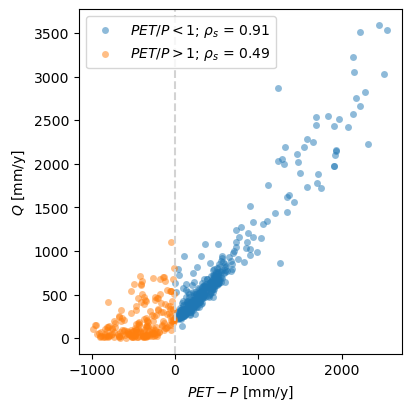

In [2]:
# define function that plots the climatic water balance against streamflow
def plot_climatic_water_balance(*args):
        
    # create figure
    fig = plt.figure(figsize=(4, 4), constrained_layout=True) 
    axes = plt.axes()
    
    # plot vertical line at x = 0
    axes.axvline(c='lightgrey', linestyle='--') 
    
    # calculate correlation for energy- and water-limited catchments
    r_sp_energy_limited, _ = stats.spearmanr(df.loc[df["aridity_class"] == 0, "climatic_water_balance"], 
                                             df.loc[df["aridity_class"] == 0, "streamflow"], nan_policy='omit')
    r_sp_water_limited, _ = stats.spearmanr(df.loc[df["aridity_class"] == 1, "climatic_water_balance"],
                                            df.loc[df["aridity_class"] == 1, "streamflow"], nan_policy='omit')
    
    # plot climatic water balance against streamflow separated into energy- and water-limited catchments
    # to get annual values we multiply the daily values by 365
    im = axes.scatter(df.loc[df["aridity_class"] == 0, "climatic_water_balance"]*365, 
                      df.loc[df["aridity_class"] == 0, "streamflow"]*365,
                      s=25, c="tab:blue", alpha=0.5, lw=0, 
                      label=r"$PET/P < 1$; $\rho_s$ = " + str(np.round(r_sp_energy_limited,2)))    
    im = axes.scatter(df.loc[df["aridity_class"] == 1, "climatic_water_balance"]*365, 
                      df.loc[df["aridity_class"] == 1, "streamflow"]*365,
                      s=25, c="tab:orange", alpha=0.5, lw=0,
                      label=r"$PET/P > 1$; $\rho_s$ = " + str(np.round(r_sp_water_limited,2)))
    
    # specify axes, labels, etc.
    axes.set_xlabel("$PET - P$ [mm/y]")
    axes.set_ylabel("$Q$ [mm/y]")
    #axes.set_xlim([-1000, 1000])
    #axes.set_ylim([0, 2000])
    axes.legend(loc='best')
    #axes.set_aspect('equal', adjustable='box')
    #axes.grid()

# run the function
plot_climatic_water_balance()
    
%matplotlib inline

Der Zusammenhang zwischen der klimatischen Wasserbilanz und dem Abfluss ist sehr stark, inbesondere in energie-limitierten Gebieten.
Hier sollte $P - PET$ ungefähr $Q$ entsprechen, da genügend Wasser verfügbar ist und somit (fast) alle Energie für Verdunstung (d.h. $AET$) genutzt werden kann.
Der Zusammenhang ist allerdings nie perfekt. Zum einen sind Umweltdaten immer mit Unsicherheit behaftet. 
Zum anderen gibt es noch weitere Faktoren über die klimatische Wasserbilanz hinaus, die die Abflussbildung beeinflussen. Diese werden wir später erarbeiten.

## Budyko Kurve

Die Unterteilung in wasser- und energielimitiert bildet die Grundlage von Budykos Kurve. 

In energie-limitierten Gebieten (z.B. feuchte Gebiete wie Schottland oder Schweden) nähert sich die Verdunstung der potentiellen Verdunstung an.

\begin{equation}
%\tag{}
AET \rightarrow PET \label{}
\end{equation}

In wasser-limitierten Gebieten (z.B. trockene Gebiete wie Südspanien oder die Sahara) nähert sich die Verdunstung dem Niederschlag an.

\begin{equation}
%\tag{}
AET \rightarrow P \label{}
\end{equation}

Wir definieren nun neben dem Trockenheitsindex noch den sogenannten Verdunstungsindex:

\begin{equation}
\tag{7}
\psi = AET / P \label{evaporative_faction}
\end{equation}

Für zunehmend wasser-limitierte ("aride") Gebiete, nähert sich der Verdunstungsindex 1 an, da der ganze Niederschlag verdunstet.
Für zunehmend energie-limitierte ("humide") Gebiete, nähert sich der Verdunstungsindex dem Trockenheitsindex an, da alles Energie für die Verdunstung genutzt wird.

<img src="Budyko_curve.png" alt="drawing" width="400"/>

Nun schauen wir uns das ganze mit echten Daten an.

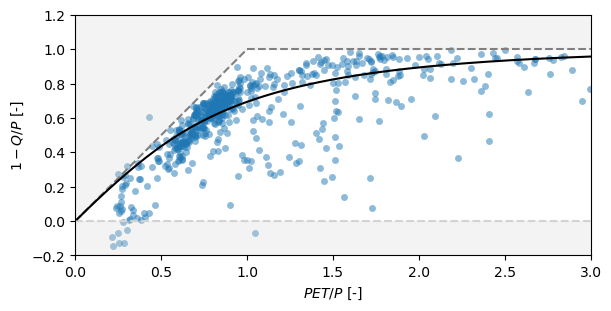

In [3]:
def plot_Budyko(plot_curve=False,*args):
    
    # create figure
    fig = plt.figure(figsize=(6, 3), constrained_layout=True)
    axes = plt.axes()
    
    # plot catchments in Budyko space
    im = axes.scatter(df["aridity"], 1-df["runoff_ratio"], s=25, alpha=0.5, lw=0) 
    
    # specify axes, labels, etc.
    axes.set_xlabel("$PET/P$ [-]")
    axes.set_ylabel("$1 - Q/P$ [-]")
    axes.set_xlim([0, 5])
    axes.set_ylim([-0.2, 1.2])
    helper_fcts.plot_Budyko_limits(df["aridity"], df["runoff_ratio"], axes)
    #axes.set_xscale('log')
    
    # plot Budyko curve
    if plot_curve == True:
        helper_fcts.plot_Budyko_curve(np.linspace(0.01,10,1000), axes)

# this function plots catchments in Budyko space as well as the Budyko curve
plot_Budyko(plot_curve=True) 

%matplotlib inline

## Budyko Kurve mit Daten
Der Plot zeigt, dass die meisten Datenpunkte den von Budyko postulierten Grenzen folgen. Die Kurve passt zwar nicht perfekt, gibt aber dennoch den generellen Trend gut wieder. 

Es gibt allerdings viele Punkte, die deutlich unter der Kurve liegen. Um diese Abweichungen zu verdeutlichen kann man die Daten mit der Kurve vergleichen und entsprechend der jeweiligen Abweichung einfärben.

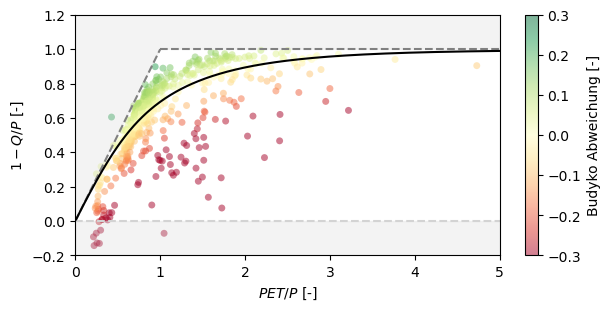

In [4]:
# define function that creates a Budyko plot coloured according to Budyko anomalies
def plot_Budyko_anomaly(*args):
    
    #todo: add dict for z name and unit
    
    # create figure
    fig = plt.figure(figsize=(6, 3), constrained_layout=True)
    axes = plt.axes()
    
    # plot catchments in Budyko space coloured according to Budyko anomalies
    im = axes.scatter(df["aridity"], 1-df["runoff_ratio"], s=25, c=df["Budyko_anomaly"], alpha=0.5, lw=0, cmap='RdYlGn') 
    
    # specify axes, labels, etc.
    axes.set_xlabel("$PET/P$ [-]")
    axes.set_ylabel("$1 - Q/P$ [-]")
    axes.set_xlim([0, 5])
    axes.set_ylim([-0.2, 1.2])
    helper_fcts.plot_Budyko_limits(df["aridity"], df["runoff_ratio"], axes)
    helper_fcts.plot_Budyko_curve(np.linspace(0.01,10,1000), axes)   
    #axes.set_xscale('log')
    cbar = fig.colorbar(im, ax=axes)
    cbar.set_label("Budyko Abweichung [-]")   
    cbar.mappable.set_clim(vmin=-0.3,vmax=0.3)

# calculate evaporative fraction using the Budyko equation and use it to calculate Budyko anomalies 
df["evaporative_fraction"] = helper_fcts.Budyko_curve(df["aridity"])
df["Budyko_anomaly"] = (1 - df["runoff_ratio"]) - df["evaporative_fraction"]

# run the function
plot_Budyko_anomaly()

%matplotlib inline

## Abweichungen von der Budyko Kurve
Abgesehen von Unsicherheiten in den Daten, welche Gründe könnte es für eine Abweichung von der Linie geben?

Überlegen Sie sich mindestens drei Gründe (Hypothesen) für die Abweichungen von der Budykokurve. 

z.B. mit ChatGPT (https://openai.com/blog/chatgpt), Google Scholar, Wikipedia, Bücher

ChatGPT prompt: Überlegen Sie sich mindestens drei Gründe (Hypothesen) für die Abweichungen von der Budykokurve, in Tabellenform als markdown code

Antwort: Natürlich! Hier sind fünf Hypothesen für mögliche Abweichungen von der Budyko-Kurve in tabellarischer Form als Markdown-Code und bitte halten Sie es kurz:

| Nr. | Hypothese für Abweichungen von der Budyko-Kurve                |
|-----|------------------------------------------------------------|
|  1  | Einfluss lokal begrenzter geologischer Gegebenheiten        |
|  2  | Änderungen in der Landnutzung und Vegetationsbedeckung      |
|  3  | Regionale klimatische Unterschiede                          |
|  4  | Menschliche Eingriffe und Wassermanagement                  |
|  5  | Hydrologische Besonderheiten in spezifischen Gebieten       |

Im nächsten Teil werden sie diese Hypotheses zur Erklärung der Abweichungen mit Daten überprüfen.

## Gründe für Abweichungen von der Budyko Kurve

Um herauszufinden, welche der oben genannten Gründe die Abweichungen verursachen könnten, können wir verschiedene Einzugsgebietseigenschaften nutzen.

todo: explain correlation
https://en.wikipedia.org/wiki/Correlation




In [5]:
# define function that creates Budyko plot coloured according to catchment attributes
def plot_Budyko_attributes(x):
    
    # todo: add dict for z name and unit and add more attributes    
    dict_names = {'p_seasonality': 'Saisonalität des Niederschlags [-]', 
                  'frac_snow': 'Schnee-Anteil [-]', 
                  'high_prec_freq': 'Anteil starker Niederschläge [%]',
                  'frac_forest': 'Wald-Anteil [-]', 
                  'slope_mean': 'Topographische Steigung [-]', 
                  'elev_mean': 'Topographische Höhe [m]', 
                  'soil_depth_pelletier': 'Bodentiefe [m]', 
                  'clay_frac': 'Ton-Anteil [-]', 
                  'carbonate_rocks_frac': 'Anteil Carbonatgestein (Karst) [-]', 
                  'geol_permeability': 'Geologische Durchlässigkeit [?]'}
    
    #print(dict_names[x])
    
    # create figure
    fig, axes = plt.subplots(figsize=(10, 3), constrained_layout=True, nrows=1, ncols=2, gridspec_kw={'width_ratios': [2, 1]})
    #axes = fig.subfigures(1, 2, wspace=0.07)
    
    # plot catchments in Budyko space coloured according to catchment attribute
    im = axes[0].scatter(df["aridity"], 1-df["runoff_ratio"], s=25, c=df[x], alpha=0.5, lw=0) #, s=df["area"]/100
    
    # specify axes, labels, etc.
    axes[0].set_xlabel("$PET/P$ [-]")
    axes[0].set_ylabel("$1 - Q/P$ [-]")
    axes[0].set_xlim([0, 5])
    axes[0].set_ylim([-0.2, 1.2])
    helper_fcts.plot_Budyko_limits(df["aridity"], df["runoff_ratio"], axes[0])
    helper_fcts.plot_Budyko_curve(np.linspace(0.01,10,1000), axes[0])
    #axes.set_xscale('log')
    cbar = fig.colorbar(im, ax=axes[0])
    #cbar.set_label(dict_names[x])    
    
    # calculate correlation
    r_sp, _ = stats.spearmanr(df[x], df["Budyko_anomaly"], nan_policy='omit')
    
    # plot vertical line at x = 0
    axes[1].axhline(c='lightgrey', linestyle='--')
    
    # plot catchment attribute against Budyko anomaly
    im = axes[1].scatter(df[x], df["Budyko_anomaly"], s=25, c=df["Budyko_anomaly"], alpha=0.5, lw=0, cmap='RdYlGn', 
                      label=r"$\rho_s$ = " + str(np.round(r_sp,2)))   
    
    # specify axes, labels, etc.
    #axes[1].set_xlabel(dict_names[x])    
    axes[1].set_ylabel("Budyko Abweichung [-]")
    axes[1].set_ylim([-1, 1])
    axes[1].legend(loc='best')
    cbar = fig.colorbar(im, ax=axes[1])
    cbar.set_label("Budyko Abweichung [-]")   
    cbar.mappable.set_clim(vmin=-0.3,vmax=0.3)


# todo: add attributes that do not matter 

# run the function
#widgets.interact(plot_Budyko_attributes, x=['p_seasonality', 'frac_snow', 'high_prec_freq',
#                                            'frac_forest', 'slope_mean', 'elev_mean',
#                                            'soil_depth_pelletier', 'clay_frac', 'carbonate_rocks_frac', 'geol_permeability'])
widgets.interact(plot_Budyko_attributes, x=['Niederschlags-Saisonalität [-]', 'Schnee-Anteil [-]', 'Anteil Carbonatgestein (Karst) [-]'], description='Einzugsgebietseigenschaft', layout={'width': 'max-content'}, disabled=False)

%matplotlib inline

interactive(children=(Dropdown(description='x', options=('Saisonalität des Niederschlags [-]', 'Schnee-Anteil …

## Einzugsgebiete außerhalb der Wasser- bzw. Energiegrenze

Einige Einzugsgebiete liegen außerhalb der Wasser- bzw. Energiegrenze.
Woran könnte das liegen?

## Annahmen der Budyko Kurve

Budyko entwickelte seine Theorie ursprünglich für große Einzugsgebiete und für lange Zeiträume.

Testen sie nun diese Annahmen, in dem sie sich die Größe der Einzugsgebiete anschauen sowie langjährige Mittelwerte auch mit jährlichen und 10-jährigen Mittelwerten vergleichen.

Welche Gründe gibt es für die Annahmen, die Budyko gemacht hat? Lässt sich das mit den Daten zeigen?

## Größe der Einzugsgebiete 

Budyko hat seine Theorie ursprünglich für große Einzugsbiete ($\gg$1000 km²) entwickelt.
Je größer ein Einzugsgebiet, desto wahrscheinlich ist es, dass sämtlichtes Wasser das Einzugsgebiet als Abfluss oder Verdunstung verlässt, und nicht beispielweise als Grundwasserabfluss.
Außerdem gleicht sich ein Teil der Schwankungen bei der Bodennutzung, der Bodenart und der Geologie in großen Gebieten aus.


In [6]:
# define function that highlights catchments in Budyko space depending on their size
def plot_Budyko_assumptions_size(x):
        
    # create figure
    fig, axes = plt.subplots(figsize=(10, 3), constrained_layout=True, nrows=1, ncols=2, gridspec_kw={'width_ratios': [2, 1]})
    #axes = fig.subfigures(1, 2, wspace=0.07)
    
    # select catchments based on their size
    if x == 'x < 200':
        df_tmp = df.loc[(df["area_gages2"]<200)]
        
    elif x == '200 < x < 500':
        df_tmp = df.loc[np.logical_and(df["area_gages2"]>200,df["area_gages2"]<500)]
        
    elif x == '500 < x < 1000':
        df_tmp = df.loc[np.logical_and(df["area_gages2"]>500,df["area_gages2"]<1000)]
        
    elif x == 'x > 1000':
        df_tmp = df.loc[(df["area_gages2"]>1000)]
        
    else:
        print("Category not available.")
        
    # plot catchments in Budyko space and highlight them according to size
    im = axes[0].scatter(df["aridity"], 1-df["runoff_ratio"], s=25, c="lightgrey", alpha=1, lw=0) 
    im = axes[0].scatter(df_tmp["aridity"], 1-df_tmp["runoff_ratio"], s=25, c="tab:red", alpha=0.5, lw=0) 
    
    # specify axes, labels, etc.
    axes[0].set_xlabel("$PET/P$ [-]")
    axes[0].set_ylabel("$1 - Q/P$ [-]")
    axes[0].set_xlim([0, 5])
    axes[0].set_ylim([-0.2, 1.2])
    helper_fcts.plot_Budyko_limits(df_tmp["aridity"], df_tmp["runoff_ratio"], axes[0])
    #axes.set_xscale('log')
    helper_fcts.plot_Budyko_curve(np.linspace(0.01,10,1000), axes[0])
    
    # plot histogram of all catchment areas
    im = axes[1].hist(df["area_gages2"], np.linspace(0,2000,40), facecolor="grey")
    
    # specify axes, labels, etc.
    axes[1].set_xlabel("Area [km$^2$]")
    axes[1].set_ylabel("Count")
    axes[1].set_xlim([0, 2000])

# run the function
widgets.interact(plot_Budyko_assumptions_size, x=['x < 200','200 < x < 500','500 < x < 1000','x > 1000'])

%matplotlib inline

interactive(children=(Dropdown(description='x', options=('x < 200', '200 < x < 500', '500 < x < 1000', 'x > 10…

## Zeitperiode

Schaut man sich langjährige Mittelwerte an, z.B. über 30 Jahre ("klimatologisches Mittel"), so wird es wahrscheinlicher, dass die Annahme zutrifft, dass keine Änderung des Speichers im Einzugsgebiet stattfindet. In einzelnen Jahren kann diese Änderung hingehen sehr groß sein und damit zu Abweichungen von der Budykokurve führen.

In [7]:
# define function that creates Budyko plots for different time periods
def plot_Budyko_assumptions_time(x):
    
    # calculate evaporative fraction and Budyko anomaly for subperiod
    df["evaporative_fraction"+'_'+x] = helper_fcts.Budyko_curve(df["aridity"])
    df["Budyko_anomaly"+'_'+x] = (1 - df["runoff_ratio"+'_'+x]) - df["evaporative_fraction"+'_'+x]
    
    # create figure
    fig, axes = plt.subplots(figsize=(10, 3), constrained_layout=True, nrows=1, ncols=2, gridspec_kw={'width_ratios': [2, 1]})
    #axes = fig.subfigures(1, 2, wspace=0.07)
      
    # plot catchments for the whole period and for a selected time period in Budyko space
    im = axes[0].scatter(df["aridity"], 1-df["runoff_ratio"], s=25, c="lightgrey", alpha=1, lw=0) 
    im = axes[0].scatter(df["aridity"+'_'+x], 1-df["runoff_ratio"+'_'+x], s=25, c="tab:red", alpha=0.5, lw=0) 
    
    # specify axes, labels, etc.
    axes[0].set_xlabel("$PET/P$ [-]")
    axes[0].set_ylabel("$1 - Q/P$ [-]")
    axes[0].set_xlim([0, 5])
    axes[0].set_ylim([-0.2, 1.2])
    helper_fcts.plot_Budyko_limits(df["aridity"], df["runoff_ratio"], axes[0])
    #axes.set_xscale('log')
    helper_fcts.plot_Budyko_curve(np.linspace(0.01,10,1000), axes[0])
    
    # plot histogram that shows Budyko anomalies for whole period and for selected time period
    df["Budyko_anomaly"+'_'+x] = (1 - df["runoff_ratio"+'_'+x]) - df["evaporative_fraction"+'_'+x]
    im = axes[1].hist(df["Budyko_anomaly"], np.linspace(-1,1,20), facecolor="grey", alpha=0.5, label='Alle Jahre')
    im = axes[1].hist(df["Budyko_anomaly"+'_'+x], np.linspace(-1,1,20), facecolor="tab:red", alpha=0.5, label=x)
    
    # specify axes, labels, etc.
    axes[1].set_xlabel("Budyko Abweichung [-]" )    
    axes[1].set_ylabel("Anzahl Einzugsgebiete")
    axes[1].set_xlim([-1, 1])
    axes[1].legend(loc='best')
    
# run the function
widgets.interact(plot_Budyko_assumptions_time, x=['1981','1982','1983','1984','1985','1981-1990','1991-2000','2001-2010'])

%matplotlib inline

interactive(children=(Dropdown(description='x', options=('1981', '1982', '1983', '1984', '1985', '1981-1990', …

# Kürzere Zeitperioden: Variabilität von Jahr zu Jahr oder von Dekade zu Dekade

Schaut man sich kürzere Zeitperioden an, z.B. einzelne Jahre, so sind bestimmte Annahmen der Budyko-Kurve nicht mehr gegeben.

Welche sind das? Und wie kann man das mit Daten nachvollziehen?


In [8]:
# define function that highlights a single catchment in Budyko space and how it changes with time
def plot_Budyko_single_catchment(x):
        
    # create figure
    fig, axes = plt.subplots(figsize=(10, 3), constrained_layout=True, nrows=1, ncols=2, gridspec_kw={'width_ratios': [2, 1]})
    #axes = fig.subfigures(1, 2, wspace=0.07)
    
    # todo: add info on selected catchments
    
    # select years
    years = ['1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990']
    aridity_tmp = np.zeros(len(years))
    runoff_ratio_tmp = np.zeros(len(years))
    precipitation_tmp = np.zeros(len(years))
    i = 0
    for year in years:
        aridity_tmp[i] = df.loc[df["gauge_id"]==x, "aridity"+'_'+year]
        runoff_ratio_tmp[i] = df.loc[df["gauge_id"]==x, "runoff_ratio"+'_'+year]
        precipitation_tmp[i] = df.loc[df["gauge_id"]==x, "precipitation"+'_'+year]
        i = i+1

    # plot catchments in Budyko space and highlight individual catchments
    im = axes[0].scatter(df["aridity"], 1-df["runoff_ratio"], s=25, c="lightgrey", alpha=1, lw=0)
    im = axes[0].scatter(aridity_tmp, 1-runoff_ratio_tmp, s=25, c=np.array(years).astype(float), alpha=1.0, lw=0, cmap='YlGnBu') 
    im = axes[0].plot(aridity_tmp, 1-runoff_ratio_tmp, c='grey', alpha=0.75) 
    
    # specify axes, labels, etc.
    axes[0].set_xlabel("$PET/P$ [-]")
    axes[0].set_ylabel("$1 - Q/P$ [-]")
    axes[0].set_xlim([0, 5])
    axes[0].set_ylim([-0.2, 1.2])
    helper_fcts.plot_Budyko_limits(df["aridity"], df["runoff_ratio"], axes[0])
    #axes.set_xscale('log')
    helper_fcts.plot_Budyko_curve(np.linspace(0.01,10,1000), axes[0]) 
    
    # plot time series for individual catchments
    im = axes[1].plot(np.array(years).astype(float), aridity_tmp, c='tab:green', alpha=0.75, label='PET/P')   
    im = axes[1].plot(np.array(years).astype(float), 1-runoff_ratio_tmp, c='tab:blue', alpha=0.75, label='1-Q/P')   
   
    # specify axes, labels, etc.
    axes[1].set_xlabel("Year")    
    axes[1].set_ylabel("[-]")
    axes[1].legend(loc='best')
    
# run the function
widgets.interact(plot_Budyko_single_catchment, x=[1013500, 8196000, 11124500, 13023000, 14309500])

%matplotlib inline    

interactive(children=(Dropdown(description='x', options=(1013500, 8196000, 11124500, 13023000, 14309500), valu…

# Die Rolle der Geologie am Beispiel England

Nun schauen wir uns noch an wie Landschaftseigenschaften, wie z.B. die Geologie, die langfristige Wasserbilanz beeinflussen können.

In England zeigt sich ein besonders starker Kontrast. Viele Kreide-Gebiete haben sehr ergiebige Grundwasserleiter, wohingegen anderen Gebiete in England häufig wenig aktives Grundwasser aufweisen. 

Was könnte die Folge davon sein?


In [10]:
# load data into workspace
df_GB = pd.read_csv("results/camels_GB_processed.csv")

# calculate evaporative fraction using the Budyko equation and use it to calculate the Budyko anomaly
df_GB["evaporative_fraction"] = helper_fcts.Budyko_curve(df_GB["aridity"])
df_GB["Budyko_anomaly"] = (1 - df_GB["runoff_ratio"]) - df_GB["evaporative_fraction"]

# choose only benchmark catchments ("near-natural")
df_GB = df_GB.loc[df_GB["benchmark_catch"] == 'Y']

In [ ]:
# define function that creates a Budyko plot for catchments in Great Britain
def plot_Budyko_attributes_GB(x):
    
    # create figure
    fig, axes = plt.subplots(figsize=(10, 3), constrained_layout=True, nrows=1, ncols=2, gridspec_kw={'width_ratios': [2, 1]})
    
    # plot catchments in Budyko space coloured according to catchment attribute
    im = axes[0].scatter(df_GB["aridity"], 1-df_GB["runoff_ratio"], s=25, c=df_GB[x], alpha=0.5, lw=0) #, s=df_GB["area"]/100
    
    # specify axes, labels, etc.
    axes[0].set_xlabel("$PET/P$ [-]")
    axes[0].set_ylabel("$1 - Q/P$ [-]")
    axes[0].set_xlim([0, 1.2])
    axes[0].set_ylim([-0.6, 1.2])
    helper_fcts.plot_Budyko_limits(df_GB["aridity"], df_GB["runoff_ratio"], axes[0])
    helper_fcts.plot_Budyko_curve(np.linspace(0.01,10,1000), axes[0])
    #axes.set_xscale('log')
    cbar = fig.colorbar(im, ax=axes[0])
    #cbar.set_label(dict_names[x])    
    
    # calculate correlation
    r_sp, _ = stats.spearmanr(df_GB[x], df_GB["Budyko_anomaly"], nan_policy='omit')    
    
    # plot vertical line at x = 0
    axes[1].axhline(c='lightgrey', linestyle='--')
    
    # plot catchment attribute against Budyko anomaly
    im = axes[1].scatter(df_GB[x], df_GB["Budyko_anomaly"], s=25, c=df_GB["Budyko_anomaly"], alpha=0.5, lw=0, cmap='RdYlGn', 
                      label=r"$\rho_s$ = " + str(np.round(r_sp,2)))   
    
    # specify axes, labels, etc.
    #axes[1].set_xlabel(dict_names[x])  
    axes[1].set_ylim([-1, 1])  
    axes[1].set_ylabel("Budyko Abweichung [-]")
    axes[1].legend(loc='best')
    cbar = fig.colorbar(im, ax=axes[1])
    cbar.set_label("Budyko Abweichung [-]")   
    cbar.mappable.set_clim(vmin=-0.3,vmax=0.3)

# todo: rename attributes  
# todo: add attributes that do not matter 

    
"""
dict_names = {'frac_high_perc': '% Grundwasserleiter hoch',
                  'frac_low_perc': '% Grundwasserleiter niedrig',
                  'no_gw_perc': '% kein Grundwasserleiter',
                  'baseflow_index': 'BFI'}
"""
    
# run the function
widgets.interact(plot_Budyko_attributes_GB, x=['soil_depth_pelletier', 'clay_perc', 'conductivity_cosby',
                                               'frac_high_perc', 'inter_high_perc', 'no_gw_perc', 'baseflow_index_ceh',
                                               'reservoir_cap', 'groundwater_abs', 'surfacewater_abs', 'discharges'])

%matplotlib inline

interactive(children=(Dropdown(description='x', options=('soil_depth_pelletier', 'clay_perc', 'conductivity_co…

# Ende der Vorlesung